# SCALES low-res SED example - PHYSICAL OPTICS LENSLET PSFS

This notebook runs through all the steps for generating a raw SCALES image using either:

(1) a target spectrum in erg/s/cm^2/um + a PSF
OR
(2) a model datacube with fluxes in erg/s/cm^2/um

You don't need to change any of the configuration stuff at the beginning if you don't want to. There are comments that describe some parameters that you might be interested in adjusting.

Right now we just have the 2-5 um mode enabled. In the future you'll be able to switch to other low-res modes. To do that all you have to do is change arg_spaxel['min_wavelength'] and arg_spaxel['max_wavelength'] at the bottom of the "Configure SCALES Mode" section.

This example just uses PHOENIX models to set up simple stellar targets as "Target" objects. It then uses PHOENIX models to make an example model datacube that you can feed to the simulator. You can replace that with whatever scene you like, as long as the dimensions match the number of spaxels in each dimension (108 by 108). 

In the end it does a simple aperture extraction to generate a datacube. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

Adjust minimum and maximum wavelength if we want to

In [5]:
arg_spaxel['min_wavelength'] = 2.0 #minimum wavelength in microns
arg_spaxel['max_wavelength'] = 5.2 #maximum wavelength in microns

## Set up lenslet traces

replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 2.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
replacing 5.0
(341, 56, 56)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

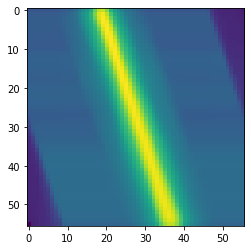

In [6]:
lens = Lenslet(arg_spaxel)
lens.get_shifts()
lens.make_trace(phys=True)

(341, 56, 56)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

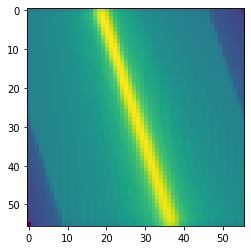

In [7]:
lens = Lenslet(arg_spaxel)
lens.get_shifts()
lens.make_trace(phys=False)

In [9]:
print(lens.trace.shape)

(341, 56, 56)
